# Assignment 3

## Guidelines

> Remember to add an explanation of what you do using markdown, and to comment your code. Please *be brief*.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> Make sure your notebooks have been run when you sumit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.

## Grading policy
> As follows:
>
> * 80 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious.
> 
> Note that there are no extras for this assignment, as all 100 points are accrued via questions. 

**The AUC code of conduct applies to this assignment: please only submit your own work.**

---

# Introduction

In this assignment, you will build and compare classifiers for measuring the **sentiment of tweets related to COVID-19**.

The dataset you will work with is [publicly available in Kaggle](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) (and attached to the assignment for your convenience). Make sure to check its minimal Kaggle documentation before starting.

This is a real dataset, and therefore messy. It is possible that you won't achieve great results on the classification task with your classifier. That is normal, don't worry about it! You also may find text encoding issues with this dataset. Try to find a simple solution to this problem, I don't think there is an easy way to fix it completely for these files.

*Please note: this dataset should not but might contain content which could be considered as offensive.*

---

# Skeleton pipeline (25 points)

## Question 1 (10 points)

Your dataset contains tweets, including handlers, hashtags, URLs, etc. Set-up a **minimal pre-processing pipeline** for them (focus on the `OriginalTweet` column), possibly including:

* Tokenization
* Filtering
* Lemmatization/Stemming

Please note that what to include is up to you, motivate your choices and remember that more is not necessarily better: if you are not sure why you are doing something, it might be better not to. Feel free to use NLTK, spaCy or anything else you like here.

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("data/Corona_NLP_train.csv", encoding="ISO-8859-1")

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


*Note: we only really use the `OriginalTweet` and `Sentiment` columns for this assignment.*

In [4]:
# your code here
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TweetTokenizer to ensure reasonable tokenization for tweets
tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
lemmatizer = nltk.WordNetLemmatizer()

# Define a preprocessing function and use it as a parameter
# later when using sklearn vectorizer: here I only do lower-casify and lemmatization
# as some special symbols may mean something in tweets
# stopwords can be excluded in sklearn vectorizer parameters as well
def lemmatize_processor(text):
    un2wn_mapping = {"VERB" : wn.VERB, "NOUN" : wn.NOUN, "ADJ" : wn.ADJ, "ADV" : wn.ADV}
    text_lemmatized = []
    # tokenization based on sentences for a more accurate PoS tagging and lemmatization
    sentences = nltk.sent_tokenize(text, language = 'english')
    tokenized_sents = [nltk.word_tokenize(sent) for sent in sentences]
    pos_sents = [nltk.pos_tag(token_sent,tagset = 'universal') for token_sent in tokenized_sents]
    
    for sentence in pos_sents:
        lemmatized_sentence = []
        for w, p in sentence:
            if p in un2wn_mapping.keys():
                lemma = lemmatizer.lemmatize(w.lower(), pos = un2wn_mapping[p])
            else:
                lemma = lemmatizer.lemmatize(w.lower())
            lemmatized_sentence.append(lemma)
        # Need to gurantee members of the list are strings and eventually joining together
        text_lemmatized.append(' '.join(lemmatized_sentence))

    return ' '.join(text_lemmatized)

count_vectorizer = CountVectorizer(preprocessor=lemmatize_processor, tokenizer=tknzr.tokenize, stop_words='english')
tfidf_vectorizer = TfidfVectorizer(preprocessor=lemmatize_processor, tokenizer=tknzr.tokenize, stop_words='english', use_idf=True, smooth_idf=True)

In [5]:
Original_Tweet_trainfile = df_train['OriginalTweet'].values
Sentiment_trainfile = df_train['Sentiment'].values

# Encode sentiment rating into numeric labels for the training
# (turns out no need for Log and SVM, as there is an innate transformation in log regression fit)
sentiment_label_mapping = {'Extremely Negative': -2, 'Negative': -1, 'Neutral': 0, 
                           'Positive': 1, 'Extremely Positive': 2}

def custom_label_encoding(label):
    return sentiment_label_mapping[label]

sentiment_encoded = [custom_label_encoding(label) for label in Sentiment_trainfile]

# Add sentiment numeric labels to the dataframe and store it to a var
df_train['Sentiment_label'] = sentiment_encoded
Sentiment_label_train = df_train['Sentiment_label'].values

print(Original_Tweet_trainfile.shape, Sentiment_trainfile.shape, len(sentiment_encoded))
df_train.head()

(41157,) (41157,) 41157


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-2


In [6]:
Original_Tweet_trainfile[2]

'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P'

In [7]:
lemmatize_processor('hello I think passed')

'hello i think pass'

---

## Question 2 (5 points)

**Split your data into a train and a validation set**. You can use 85% for training and 15% for validation, or similar proportions. Remember to shuffle your data before splitting, specifying a seed to be able to replicate your results.

In [8]:
# your code here
# Reminder: the split can be carried out directly on raw text data
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(Original_Tweet_trainfile, Sentiment_trainfile, 
                                                                test_size=0.15, random_state=42, shuffle = True)

---

## Question 3 (10 points)

Write a function which, given as input a set of predictions and a set of ground truth labels, prints out a **classification report** including:
* Name of the method
* Accuracy
* Precision, recall and F1 measure
* An example of a correctly classified datapoint
* An example of a wrongly classified datapoint

In [9]:
# your code here
from sklearn.metrics import classification_report, accuracy_score
import random

def report(predictions, ground_truth_labels, method, X_text=None):
    print(f"The classification report for {method}.")
    print(f"Accuracy: {accuracy_score(ground_truth_labels, predictions)}")
    print()
    print(classification_report(ground_truth_labels, predictions))

    # Collect indices of correct and wrong classifactions in lists
    correct_indices = [i for i in range(len(ground_truth_labels)) if ground_truth_labels[i] == predictions[i]]
    wrong_indices = [i for i in range(len(ground_truth_labels)) if ground_truth_labels[i] != predictions[i]]

    # Set X_text as an optional argument for testing, 
    # if not none, randomly chose an index from lists respectively
    # and retrieve in X_train where text shuffle takes place together with
    # labels, just don't use original text data
    if X_text is not None:
        if correct_indices:
            correct_index = random.choice(correct_indices)
            
            print("\nExample of a correctly classified datapoint:")
            print("True Label:", ground_truth_labels[correct_index])
            print("Predicted Label:", predictions[correct_index])
            print("Text:", X_text[correct_index])           

        if wrong_indices:
            wrong_index = random.choice(wrong_indices)

            print("\nExample of a wrongly classified datapoint:")
            print("True Label:", ground_truth_labels[wrong_index])
            print("Predicted Label:", predictions[wrong_index])
            print("Text:", X_text[wrong_index])

---

# Classifying (55 points)

## Question 4 (15 points)

An important first step when dealing with a real-world task is establishing a **solid baseline**. The baseline allows to a) develop the first full pipeline for your task, and b) to have something to compare against when you develop more advanced models.

Pick a method to use as a baseline. *A good option might be a TF-IDF Logistic Regression*. Feel free to use scikit-learn or another library of choice. See [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for more options.

Use your classification report function and the validation set to report on the performance of your baseline. *Pay attention: the validation data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed it, use the same fitted vectorizer to transform your validation data.*

In [10]:
# your code here
# Baseline default tfidf-LogReg model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
logreg.fit(X_train_tfidf, y_train)

F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
X_validation_tfidf = tfidf_vectorizer.transform(X_validation)
y_hat_validation = logreg.predict(X_validation_tfidf)

# Baseline default tfidf-LogReg model validation report
report(y_hat_validation, y_validation, 'tfidf_log', X_text = X_validation)

The classification report for tfidf_log.
Accuracy: 0.5761256883705863

                    precision    recall  f1-score   support

Extremely Negative       0.66      0.51      0.58       790
Extremely Positive       0.67      0.55      0.61      1005
          Negative       0.53      0.54      0.53      1516
           Neutral       0.64      0.64      0.64      1176
          Positive       0.51      0.61      0.56      1687

          accuracy                           0.58      6174
         macro avg       0.60      0.57      0.58      6174
      weighted avg       0.58      0.58      0.58      6174


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: New York s Food Pantries Face An  Unprecedented And Extreme Uptick In Need  via

Example of a wrongly classified datapoint:
True Label: Neutral
Predicted Label: Positive
Text: Safety Advice If You Must Visit the Grocery Store   Is isolation getting to you Here s how to know   and what exp

In [12]:
# Tuning for TFIDF-LogRegression
from sklearn.model_selection import GridSearchCV

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1,1,10],
    'solver': ['lbfgs', 'liblinear']
}


grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)


grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\anaconda\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "F:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.5718497341791421


In [13]:
logreg_bt = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')
logreg_bt.fit(X_train_tfidf, y_train)
y_hat_validation_tfidf_bt = logreg_bt.predict(X_validation_tfidf)

report(y_hat_validation_tfidf_bt, y_validation, 'tuned_tfidf_log', X_text = X_validation)

The classification report for tuned_tfidf_log.
Accuracy: 0.6059280855199223

                    precision    recall  f1-score   support

Extremely Negative       0.61      0.64      0.63       790
Extremely Positive       0.65      0.68      0.67      1005
          Negative       0.59      0.48      0.53      1516
           Neutral       0.64      0.77      0.70      1176
          Positive       0.56      0.55      0.55      1687

          accuracy                           0.61      6174
         macro avg       0.61      0.62      0.61      6174
      weighted avg       0.60      0.61      0.60      6174


Example of a correctly classified datapoint:
True Label: Extremely Negative
Predicted Label: Extremely Negative
Text: Quick comparative analysis of the impact of the COVID 19 crisis on base metal prices and which metal is most likely to over perform when the recovery comes

Example of a wrongly classified datapoint:
True Label: Negative
Predicted Label: Neutral
Text: Tata Cons

---

## Question 5 (25 points)

Try now to **beat your baseline**. Feel free to use scikit-learn or another library of choice. See [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for more options.

How to beat the baseline? There are many ways:
1. You could have a better text representation (e.g., using PPMI instead of TF-IDF, note that this is challenging because there is no ready-made scikit-learn vectorizer for this).
2. You can pick a more powerful model (e.g., random forests or SVMs).
3. You have to find good hyperparameters for your model, and not just use the default ones.

Regarding point 3 above, make sure to perform some hyperparameter searching using [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [randomized search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

Use your classification report function and the validation set to report on the performance of your baseline. *Pay attention: the validation data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed it, use the same fitted vectorizer to transform your validation data.*

In [14]:
# Count vectorized vars
X_train_count = count_vectorizer.fit_transform(X_train)
X_validation_count = count_vectorizer.transform(X_validation)

F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


In [15]:
# Count-based logistic regression
logreg.fit(X_train_count, y_train)
y_hat_validation_count = logreg.predict(X_validation_count)

report(y_hat_validation_count, y_validation, 'count_log', X_text = X_validation)

The classification report for count_log.
Accuracy: 0.5926465824425008

                    precision    recall  f1-score   support

Extremely Negative       0.62      0.58      0.60       790
Extremely Positive       0.67      0.63      0.65      1005
          Negative       0.55      0.51      0.53      1516
           Neutral       0.60      0.73      0.66      1176
          Positive       0.56      0.56      0.56      1687

          accuracy                           0.59      6174
         macro avg       0.60      0.60      0.60      6174
      weighted avg       0.59      0.59      0.59      6174


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: So although Argos stand alone stores are closed they are still delivering from online shopping, how are they an essential product? They are putting their drivers and public at risk
#argos @Argos_Online #lockdown #coronavirus

Example of a wrongly classified datapoint:
True Label: Positi

F:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# Tuning for Count-LogRegression
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1,1,10],
    'solver': ['lbfgs', 'liblinear']
}


grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)


grid_search.fit(X_train_count, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\anaconda\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "F:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.5862280640898702


In [17]:
# Tuned Count-LogRegression
logreg_t = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')
logreg_t.fit(X_train_count, y_train)
y_hat_validation_count_t = logreg_t.predict(X_validation_count)

report(y_hat_validation_count_t, y_validation, 'tuned_count_log', X_text = X_validation)

The classification report for tuned_count_log.
Accuracy: 0.6073858114674441

                    precision    recall  f1-score   support

Extremely Negative       0.67      0.68      0.67       790
Extremely Positive       0.67      0.71      0.69      1005
          Negative       0.56      0.48      0.51      1516
           Neutral       0.63      0.75      0.68      1176
          Positive       0.56      0.53      0.54      1687

          accuracy                           0.61      6174
         macro avg       0.62      0.63      0.62      6174
      weighted avg       0.60      0.61      0.60      6174


Example of a correctly classified datapoint:
True Label: Extremely Positive
Predicted Label: Extremely Positive
Text: Coffee maker available for Kshs 3500.
Make your order via 0715783634.
Remember to keep safe during this COVID-19 outbreak. Online shopping is a great idea for you and your family.
#household #homedecor #kitchendecor #glammyhomekenya https://t.co/roqoqrP5Kb

Exa

In [18]:
# your code here
# Using a default tfidf-based SVM model
from sklearn.linear_model import SGDClassifier

SVM = SGDClassifier(random_state = 42)

SVM.fit(X_train_tfidf, y_train)
y_hat_validation_SVM = SVM.predict(X_validation_tfidf)

report(y_hat_validation_SVM, y_validation, 'SVM_tfidf', X_text = X_validation)

The classification report for SVM_tfidf.
Accuracy: 0.5323939099449303

                    precision    recall  f1-score   support

Extremely Negative       0.48      0.81      0.60       790
Extremely Positive       0.52      0.83      0.64      1005
          Negative       0.52      0.28      0.36      1516
           Neutral       0.59      0.73      0.65      1176
          Positive       0.55      0.32      0.40      1687

          accuracy                           0.53      6174
         macro avg       0.53      0.59      0.53      6174
      weighted avg       0.54      0.53      0.50      6174


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: Happening Now: White House #Coronavirus Task Force providing an update on the pandemic. Watch live here: https://t.co/HwdJDKqQXp https://t.co/8Xyr7hkONM

Example of a wrongly classified datapoint:
True Label: Extremely Negative
Predicted Label: Negative
Text: Beware of counterfeiters The 

In [19]:
# Tuning for tfidf-based SVM
from sklearn.model_selection import GridSearchCV

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['optimal', 'constant', 'adaptive']
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=SGDClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

# 执行网格搜索
grid_search.fit(X_train_tfidf, y_train)

# 输出最佳参数组合和最佳得分
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\anaconda\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "F:\anaconda\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "F:\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_param

Best Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'penalty': 'l1'}
Best Accuracy: 0.5596721841011172


In [20]:
# Tuned tfidf-based SVM_2 Model
SVM_2 = SGDClassifier(alpha=0.0001, learning_rate='optimal', loss='modified_huber', penalty='l1', random_state = 42)

SVM_2.fit(X_train_tfidf, y_train)
y_hat_validation_SVM_2 = SVM_2.predict(X_validation_tfidf)

report(y_hat_validation_SVM_2, y_validation, 'SVM_2_tfidf',X_text = X_validation)

The classification report for SVM_2_tfidf.
Accuracy: 0.577259475218659

                    precision    recall  f1-score   support

Extremely Negative       0.55      0.67      0.60       790
Extremely Positive       0.60      0.72      0.65      1005
          Negative       0.56      0.40      0.46      1516
           Neutral       0.63      0.76      0.69      1176
          Positive       0.54      0.49      0.51      1687

          accuracy                           0.58      6174
         macro avg       0.58      0.61      0.58      6174
      weighted avg       0.57      0.58      0.57      6174


Example of a correctly classified datapoint:
True Label: Extremely Negative
Predicted Label: Extremely Negative
Text: The COVID-19 pandemic and global oil price wars are having an economic impact worldwide, but one consequence is lower fuel prices at Australian petrol pumps for the foreseeable.

#UniMelbPursuit @dprbyrne @BusEcoNews  
https://t.co/aB6phfFIwI

Example of a wrongly c

In [21]:
# your code here
# Using a default count-based SVM model
SVM.fit(X_train_count, y_train)
y_hat_validation_SVM_c = SVM.predict(X_validation_count)

report(y_hat_validation_SVM_c, y_validation, 'SVM_count',X_text = X_validation)

The classification report for SVM_count.
Accuracy: 0.5607385811467445

                    precision    recall  f1-score   support

Extremely Negative       0.57      0.68      0.62       790
Extremely Positive       0.68      0.66      0.67      1005
          Negative       0.49      0.42      0.45      1516
           Neutral       0.58      0.72      0.64      1176
          Positive       0.52      0.47      0.50      1687

          accuracy                           0.56      6174
         macro avg       0.57      0.59      0.57      6174
      weighted avg       0.56      0.56      0.56      6174


Example of a correctly classified datapoint:
True Label: Positive
Predicted Label: Positive
Text: People who use sell drugs help needed Is there a change in the market Is the market stable Have prices gone up Have deals got smaller Are there more adulterated drugs Are new drugs appearing Are people shifting to alternatives

Example of a wrongly classified datapoint:
True Label: Nega

In [22]:
# Tuning for count-based SVM model
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['optimal', 'constant', 'adaptive']
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=SGDClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

# 执行网格搜索
grid_search.fit(X_train_count, y_train)

# 输出最佳参数组合和最佳得分
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "F:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\anaconda\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "F:\anaconda\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "F:\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parame

Best Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l1'}
Best Accuracy: 0.5768230940761756


In [23]:
# Tuned count-based SVM_3 Model
SVM_3 = SGDClassifier(alpha=0.0001, learning_rate='optimal', loss='hinge', penalty='l1', random_state = 42)

SVM_3.fit(X_train_count, y_train)
y_hat_validation_SVM_3_c = SVM_3.predict(X_validation_count)

report(y_hat_validation_SVM_3_c, y_validation, 'SVM_3_count',X_text = X_validation)

The classification report for SVM_3_count.
Accuracy: 0.5962099125364432

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.70      0.67       790
Extremely Positive       0.70      0.74      0.72      1005
          Negative       0.51      0.45      0.48      1516
           Neutral       0.59      0.83      0.69      1176
          Positive       0.57      0.43      0.49      1687

          accuracy                           0.60      6174
         macro avg       0.60      0.63      0.61      6174
      weighted avg       0.59      0.60      0.59      6174


Example of a correctly classified datapoint:
True Label: Extremely Negative
Predicted Label: Extremely Negative
Text: #CoronaCrisis Panic buyers hoarding food should be treated as looters in a riot and be sentenced to self isolate for two weeks in a cell. I cannot believe how selfish people can be! It is appalling behaviour.

Example of a wrongly classified datapoint:
True Label: 

---

## Question 6 (15 points)

Design, develop and train a (simple!) **neural network-based classifier** for this task, using scikit-learn or PyTorch. The classifier can have the structure that you prefer, just make sure to motivate your choices. If in doubt, try with a bag of embeddings classifier.

*Note: an NN-based classifier with scikit-learn yields 5 points max; one with PyTorch yields 10 points max; one with PyTorch and pre-trained embeddings yields 15 points max.*

Use your classification report function and the validation set to report on the performance of your baseline. *Pay attention: the validation data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed it, use the same fitted vectorizer to transform your validation data.*

In [24]:
# your code here
# Default tfidf-based MLP model
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(solver='lbfgs')

MLP.fit(X_train_tfidf, y_train)
y_hat_validation_MLP = MLP.predict(X_validation_tfidf)

report(y_hat_validation_MLP, y_validation, 'MLP_tfidf',X_text = X_validation)

The classification report for MLP_tfidf.
Accuracy: 0.6062520246193716

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.63      0.64       790
Extremely Positive       0.67      0.66      0.67      1005
          Negative       0.57      0.56      0.56      1516
           Neutral       0.69      0.59      0.64      1176
          Positive       0.54      0.61      0.58      1687

          accuracy                           0.61      6174
         macro avg       0.62      0.61      0.62      6174
      weighted avg       0.61      0.61      0.61      6174


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: My short video on why gold prices have not performed as well in the current uncertain environment 19

Example of a wrongly classified datapoint:
True Label: Negative
Predicted Label: Positive
Text: Don t be afraid of It is curable it has it s own time just take precautionary measures A 

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [25]:
# Default count-based MLP model
MLP.fit(X_train_count, y_train)
y_hat_validation_MLP_c = MLP.predict(X_validation_count)

report(y_hat_validation_MLP_c, y_validation, 'MLP_count', X_text = X_validation)

The classification report for MLP_count.
Accuracy: 0.6018788467768059

                    precision    recall  f1-score   support

Extremely Negative       0.66      0.63      0.65       790
Extremely Positive       0.69      0.66      0.67      1005
          Negative       0.54      0.54      0.54      1516
           Neutral       0.67      0.66      0.67      1176
          Positive       0.54      0.57      0.55      1687

          accuracy                           0.60      6174
         macro avg       0.62      0.61      0.62      6174
      weighted avg       0.60      0.60      0.60      6174


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: Unfortunately, another way for con artists to prey on the #elderly via #coronavirus #scams #grandparents
https://t.co/bBLLT0a8A1

Example of a wrongly classified datapoint:
True Label: Negative
Predicted Label: Extremely Negative
Text: @HenrySmithUK can you raise with Boris please that 

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [26]:
# First-round tuning for tfidf-based MLP model
params = {
    'hidden_layer_sizes': [(100,),(50,)],
    'alpha': [0.0001, 0.001],
}
grid_search = GridSearchCV(estimator=MLPClassifier(solver='lbfgs'),
                           param_grid=params,
                           scoring='accuracy',
                           cv=2,
                           n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Best Accuracy: 0.5454933959502717


F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [27]:
# Tuned tfidf-based MLP_2 model with single hidden layer with size of 100
MLP_2 = MLPClassifier(solver='lbfgs',alpha = 0.0001, hidden_layer_sizes=(100,))

MLP_2.fit(X_train_tfidf, y_train)
y_hat_validation_MLP_2 = MLP_2.predict(X_validation_tfidf)

report(y_hat_validation_MLP_2, y_validation, 'MLP_tfidf_2',X_text = X_validation)

The classification report for MLP_tfidf_2.
Accuracy: 0.6114350502105604

                    precision    recall  f1-score   support

Extremely Negative       0.65      0.65      0.65       790
Extremely Positive       0.67      0.68      0.68      1005
          Negative       0.57      0.54      0.55      1516
           Neutral       0.64      0.66      0.65      1176
          Positive       0.57      0.58      0.58      1687

          accuracy                           0.61      6174
         macro avg       0.62      0.62      0.62      6174
      weighted avg       0.61      0.61      0.61      6174


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: Americans Stock Up On Food as COVID-19 Concerns Rise. the only thing i bought on this list is a few extra boxes of pasta...https://t.co/C0z5g5aTmj

Example of a wrongly classified datapoint:
True Label: Neutral
Predicted Label: Positive
Text: HCASA Board statement on consumer advocate p

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [28]:
# Second-round tuning for tfidf-based MLP model
params = {
    'hidden_layer_sizes': [(100,),(100,50)],
    'alpha': [0.0001, 0.001],
}
grid_search = GridSearchCV(estimator=MLPClassifier(solver='lbfgs'),
                           param_grid=params,
                           scoring='accuracy',
                           cv=2,
                           n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}
Best Accuracy: 0.5594142120825185


F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [29]:
# Tuned tfidf-based MLP model with 2 hidden layers
MLP_3 = MLPClassifier(solver='lbfgs',alpha = 0.001, hidden_layer_sizes=(100,50))

MLP_3.fit(X_train_tfidf, y_train)
y_hat_validation_MLP_3 = MLP_3.predict(X_validation_tfidf)

report(y_hat_validation_MLP_3, y_validation, 'MLP_tfidf_3',X_text = X_validation)

The classification report for MLP_tfidf_3.
Accuracy: 0.6214771622934888

                    precision    recall  f1-score   support

Extremely Negative       0.68      0.61      0.65       790
Extremely Positive       0.68      0.68      0.68      1005
          Negative       0.57      0.59      0.58      1516
           Neutral       0.66      0.66      0.66      1176
          Positive       0.58      0.59      0.59      1687

          accuracy                           0.62      6174
         macro avg       0.64      0.63      0.63      6174
      weighted avg       0.62      0.62      0.62      6174


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: Huntsman Corp announced it is producing hand sanitizer and will donate the first five tons to the Huntsman Cancer Institute and other University of Utah health providers Find the latest updates on the in Utah here

Example of a wrongly classified datapoint:
True Label: Neutral
Predict

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [30]:
# Tuning for the count-based MLP model
params = {
    'hidden_layer_sizes': [(50,),(100,),(100,50)],
    'alpha': [0.0001, 0.001],
}
grid_search = GridSearchCV(estimator=MLPClassifier(solver='lbfgs'),
                           param_grid=params,
                           scoring='accuracy',
                           cv=2,
                           n_jobs=-1)

grid_search.fit(X_train_count, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}
Best Accuracy: 0.5848557076356267


F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [31]:
# Tuned count-based MLP model
MLP_4 = MLPClassifier(solver='lbfgs',alpha = 0.0001, hidden_layer_sizes=(100,50))

MLP_4.fit(X_train_count, y_train)
y_hat_validation_MLP_4 = MLP_4.predict(X_validation_count)

report(y_hat_validation_MLP_4, y_validation, 'MLP_count_4',X_text = X_validation)

The classification report for MLP_count_4.
Accuracy: 0.6504697116942015

                    precision    recall  f1-score   support

Extremely Negative       0.72      0.67      0.69       790
Extremely Positive       0.75      0.68      0.71      1005
          Negative       0.59      0.59      0.59      1516
           Neutral       0.71      0.70      0.71      1176
          Positive       0.59      0.64      0.61      1687

          accuracy                           0.65      6174
         macro avg       0.67      0.66      0.66      6174
      weighted avg       0.65      0.65      0.65      6174


Example of a correctly classified datapoint:
True Label: Positive
Predicted Label: Positive
Text: Sourland Mountain Spirits has switched from producing craft spirits to producing hand sanitizer to fight #coronavirus. https://t.co/aYR6szlzuO

Example of a wrongly classified datapoint:
True Label: Positive
Predicted Label: Negative
Text: In the hour since I posted this, people have 

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


---

# Evaluating your classifiers (20 points)

## Question 7 (10 points)

Evaluate the performance of your models on the **test set**. Make sure to transform your test data as you did for your train data, and as needed for each classifier. *Pay attention: the test data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed your train and validation with it, use the same fitted vectorizer to transform your test data.*

* Report the accuracy of each classifier, as well as its precision, recall and F1 score. 
* Plot a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) for your best classifier.
* Briefly discuss your results.

In [32]:
df_test = pd.read_csv("data/Corona_NLP_test.csv")

In [33]:
# your code here
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [34]:
Original_Tweet_testfile = df_test['OriginalTweet'].values
Sentiment_testfile = df_test['Sentiment'].values

sentiment_encoded_test = [custom_label_encoding(label) for label in Sentiment_testfile]

# Add sentiment numeric labels to the dataframe and store it to a var
df_test['Sentiment_label'] = sentiment_encoded_test
Sentiment_label_test = df_test['Sentiment_label'].values

print(Original_Tweet_testfile.shape, Sentiment_testfile.shape, len(sentiment_encoded_test))
df_test.head()

(3798,) (3798,) 3798


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_label
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,-2
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,1
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,2
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,-1
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,0


In [35]:
X_test_tfidf = tfidf_vectorizer.transform(Original_Tweet_testfile)
X_test_count = count_vectorizer.transform(Original_Tweet_testfile)

y_test = Sentiment_testfile
y_test_numlabel = Sentiment_label_test

In [46]:
# Baseline tfidf-LogReg
logreg.fit(X_train_tfidf, y_train)
y_hat_test_tfidf_LogReg = logreg.predict(X_test_tfidf)

report(y_hat_test_tfidf_LogReg, y_test, 'Baseline tfidf_log on test set',X_text = Original_Tweet_testfile)
Baseline_tfidf_LogReg_ac = accuracy_score(y_test,y_hat_test_tfidf_LogReg)

The classification report for Baseline tfidf_log on test set.
Accuracy: 0.5284360189573459

                    precision    recall  f1-score   support

Extremely Negative       0.59      0.48      0.53       592
Extremely Positive       0.67      0.48      0.56       599
          Negative       0.50      0.48      0.49      1041
           Neutral       0.60      0.57      0.58       619
          Positive       0.45      0.62      0.52       947

          accuracy                           0.53      3798
         macro avg       0.56      0.52      0.54      3798
      weighted avg       0.54      0.53      0.53      3798


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: The government: Avoid large crowds. 

Us: lets all meet up at the grocery store!

#coronavirus #coronapocalypse #CoronaOutbreak #Covid_19 #CoronavirusPandemic

Example of a wrongly classified datapoint:
True Label: Extremely Positive
Predicted Label: Positive
Text:

F:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
test_ac_dict = dict()
test_ac_dict['Baseline_tfidf_LogReg'] = Baseline_tfidf_LogReg_ac
print(test_ac_dict)

{'Baseline_tfidf_LogReg': 0.5284360189573459}


In [49]:
# Baseline Count-LogReg
# Remember to fit corresponding data again 
# if classifer is not differentiated
logreg.fit(X_train_count, y_train)
y_hat_test_count_LogReg = logreg.predict(X_test_count)

report(y_hat_test_count_LogReg, y_test, 'Baseline count_log on test set', X_text = Original_Tweet_testfile)

Baseline_count_LogReg_ac = accuracy_score(y_test,y_hat_test_count_LogReg)
test_ac_dict['Baseline_count_LogReg'] = Baseline_count_LogReg_ac

The classification report for Baseline count_log on test set.
Accuracy: 0.5413375460768826

                    precision    recall  f1-score   support

Extremely Negative       0.57      0.55      0.56       592
Extremely Positive       0.65      0.55      0.60       599
          Negative       0.52      0.45      0.48      1041
           Neutral       0.55      0.66      0.60       619
          Positive       0.48      0.55      0.52       947

          accuracy                           0.54      3798
         macro avg       0.56      0.55      0.55      3798
      weighted avg       0.54      0.54      0.54      3798


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: Apple retail store closes COVID 19

Example of a wrongly classified datapoint:
True Label: Positive
Predicted Label: Extremely Positive
Text: Is there a hashtag for helping folks who WEREN'T able to go to the grocery store &amp; get 3 carts of food?

Have any major gr

F:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
# Tuned tfidf-LogReg
y_hat_test_tfidf_LogReg_bt = logreg_bt.predict(X_test_tfidf)

report(y_hat_test_tfidf_LogReg_bt, y_test, 'Tuned tfidf_log on test set', X_text = Original_Tweet_testfile)

Tuned_tfidf__LogReg_ac = accuracy_score(y_test,y_hat_test_tfidf_LogReg_bt)
test_ac_dict['Tuned_tfidf_LogReg'] = Tuned_tfidf__LogReg_ac

The classification report for Tuned tfidf_log on test set.
Accuracy: 0.5629278567667193

                    precision    recall  f1-score   support

Extremely Negative       0.59      0.60      0.59       592
Extremely Positive       0.65      0.64      0.64       599
          Negative       0.56      0.42      0.48      1041
           Neutral       0.57      0.70      0.63       619
          Positive       0.50      0.56      0.53       947

          accuracy                           0.56      3798
         macro avg       0.57      0.58      0.57      3798
      weighted avg       0.56      0.56      0.56      3798


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: Plano Independent School District is extending #planotx students' spring break by a week through March 20. https://t.co/PcfSM6u7Z4 #covid_19 #planoisd https://t.co/6pmBAFEyBD

Example of a wrongly classified datapoint:
True Label: Extremely Negative
Predicted Label: Nega

In [51]:
# Tuned count-LogReg
y_hat_test_tfidf_LogReg_t = logreg_t.predict(X_test_count)

report(y_hat_test_tfidf_LogReg_t, y_test, 'Tuned count_log on test set', X_text = Original_Tweet_testfile)

Tuned_count__LogReg_ac = accuracy_score(y_test,y_hat_test_tfidf_LogReg_t)
test_ac_dict['Tuned_count_LogReg'] = Tuned_count__LogReg_ac

The classification report for Tuned count_log on test set.
Accuracy: 0.5652975250131648

                    precision    recall  f1-score   support

Extremely Negative       0.62      0.63      0.62       592
Extremely Positive       0.68      0.65      0.66       599
          Negative       0.52      0.41      0.46      1041
           Neutral       0.59      0.71      0.64       619
          Positive       0.49      0.54      0.51       947

          accuracy                           0.57      3798
         macro avg       0.58      0.59      0.58      3798
      weighted avg       0.56      0.57      0.56      3798


Example of a correctly classified datapoint:
True Label: Positive
Predicted Label: Positive
Text: "Donald Trump reportedly tried to poach German scientists working on a cure for the coronavirus so he could secure exclusive rights to a potential vaccine for the US only." #Coronavirus 

To trump, a human life exists solely as a consumer or his pawn.

https://t.co/hdg

In [52]:
# Default tfidf-based SVM
SVM.fit(X_train_tfidf, y_train)
y_hat_test_tfidf_SVM = SVM.predict(X_test_tfidf)

report(y_hat_test_tfidf_SVM, y_test, 'Default tfidf_SVM on test set', X_text = Original_Tweet_testfile)

default_tfidf_SVM_ac = accuracy_score(y_test,y_hat_test_tfidf_SVM)
test_ac_dict['Default_tfidf_SVM'] = default_tfidf_SVM_ac

The classification report for Default tfidf_SVM on test set.
Accuracy: 0.5023696682464455

                    precision    recall  f1-score   support

Extremely Negative       0.46      0.80      0.59       592
Extremely Positive       0.52      0.76      0.62       599
          Negative       0.51      0.25      0.34      1041
           Neutral       0.55      0.67      0.60       619
          Positive       0.49      0.32      0.39       947

          accuracy                           0.50      3798
         macro avg       0.50      0.56      0.51      3798
      weighted avg       0.50      0.50      0.48      3798


Example of a correctly classified datapoint:
True Label: Extremely Negative
Predicted Label: Extremely Negative
Text: I need people to be less stupid about COVID-19. No, you do not need to stock up on TP or bottled water. Personally, I'll be buying some extra food that'll keep a while (canned, frozen, dry goods, etc.) and OTC and prescription meds that might run 

In [53]:
# Default count-based SVM
SVM.fit(X_train_count, y_train)
y_hat_test_count_SVM = SVM.predict(X_test_count)

report(y_hat_test_count_SVM, y_test, 'Default count_SVM on test set', X_text = Original_Tweet_testfile)

default_count_SVM_ac = accuracy_score(y_test,y_hat_test_count_SVM)
test_ac_dict['Default_count_SVM'] = default_count_SVM_ac

The classification report for Default count_SVM on test set.
Accuracy: 0.5260663507109005

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.65      0.59       592
Extremely Positive       0.66      0.58      0.62       599
          Negative       0.47      0.37      0.41      1041
           Neutral       0.56      0.67      0.61       619
          Positive       0.47      0.49      0.48       947

          accuracy                           0.53      3798
         macro avg       0.54      0.55      0.54      3798
      weighted avg       0.52      0.53      0.52      3798


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: When herd mentality makes you want to stockpile unnecessarily, bear in mind the only pasta left on the supermarket shelves this morning is Italian, this is how ill-informed ppl are about #Covid_19.  Take a beat,  check out the @CDCgov website and #buyItalian ? ?

Exa

In [55]:
# Tuned tfidf-based SVM_2 Model
y_hat_test_tfidf_SVM_2 = SVM_2.predict(X_test_tfidf)

report(y_hat_test_tfidf_SVM_2, y_test, 'Tuned tfidf_SVM_2 on test set', X_text = Original_Tweet_testfile)

tuned_tfidf_SVM_2_ac = accuracy_score(y_test,y_hat_test_tfidf_SVM_2)
test_ac_dict['Tuned_tfidf_SVM_2'] = tuned_tfidf_SVM_2_ac

The classification report for Tuned tfidf_SVM_2 on test set.
Accuracy: 0.5450236966824644

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.65      0.60       592
Extremely Positive       0.61      0.67      0.63       599
          Negative       0.55      0.35      0.43      1041
           Neutral       0.57      0.71      0.63       619
          Positive       0.47      0.51      0.49       947

          accuracy                           0.55      3798
         macro avg       0.55      0.58      0.56      3798
      weighted avg       0.55      0.55      0.54      3798


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: How has the impacted consumer spend across airlines cruise lines restaurants food delivery and more See our just published report

Example of a wrongly classified datapoint:
True Label: Extremely Positive
Predicted Label: Positive
Text: I understand that this virus is 

In [56]:
# Tuned count-based SVM_3 Model
y_hat_test_tfidf_SVM_3 = SVM_3.predict(X_test_count)

report(y_hat_test_tfidf_SVM_3, y_test, 'Tuned count_SVM_3 on test set', X_text = Original_Tweet_testfile)

tuned_count_SVM_3_ac = accuracy_score(y_test,y_hat_test_tfidf_SVM_3)
test_ac_dict['Tuned_count_SVM_3'] = tuned_count_SVM_3_ac

The classification report for Tuned count_SVM_3 on test set.
Accuracy: 0.5613480779357557

                    precision    recall  f1-score   support

Extremely Negative       0.62      0.69      0.65       592
Extremely Positive       0.70      0.69      0.69       599
          Negative       0.50      0.39      0.44      1041
           Neutral       0.53      0.81      0.64       619
          Positive       0.51      0.43      0.47       947

          accuracy                           0.56      3798
         macro avg       0.57      0.60      0.58      3798
      weighted avg       0.56      0.56      0.55      3798


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: BBC News - #Coronavirus: #Iceland store to open early for older shoppers https://t.co/PwaNlE6BOD #COVID19 #2019nCoV #CoronavirusUpdates #CoronavirusPandemic #PublicHealth #retail #age #NorthernIreland

Example of a wrongly classified datapoint:
True Label: Negative
Pre

In [58]:
# Default tfidf-based MLP model
MLP.fit(X_train_tfidf, y_train)
y_hat_test_tfidf_MLP = MLP.predict(X_test_tfidf)

report(y_hat_test_tfidf_MLP, y_test, 'Default tfidf_MLP on test set', X_text = Original_Tweet_testfile)

default_tfidf_MLP_ac = accuracy_score(y_test,y_hat_test_tfidf_MLP)
test_ac_dict['Default_tfidf_MLP'] = default_tfidf_MLP_ac

The classification report for Default tfidf_MLP on test set.
Accuracy: 0.5758293838862559

                    precision    recall  f1-score   support

Extremely Negative       0.65      0.58      0.61       592
Extremely Positive       0.65      0.62      0.63       599
          Negative       0.54      0.54      0.54      1041
           Neutral       0.59      0.58      0.59       619
          Positive       0.52      0.58      0.55       947

          accuracy                           0.58      3798
         macro avg       0.59      0.58      0.59      3798
      weighted avg       0.58      0.58      0.58      3798


Example of a correctly classified datapoint:
True Label: Negative
Predicted Label: Negative
Text: Due to growing concerns around COVID-19, Creemore Springs is taking additional steps to be extra vigilant to maintain the health &amp; well being of staff &amp; customers. Our Retail Store remains open, but tours are currently suspended. Updates will be provided on s

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [59]:
# Default count-based MLP model
MLP.fit(X_train_count, y_train)
y_hat_test_count_MLP = MLP.predict(X_test_count)

report(y_hat_test_count_MLP, y_test, 'Default count_MLP on test set', X_text = Original_Tweet_testfile)

default_count_MLP_ac = accuracy_score(y_test,y_hat_test_count_MLP)
test_ac_dict['Default_count_MLP'] = default_count_MLP_ac

The classification report for Default count_MLP on test set.
Accuracy: 0.5626645602948921

                    precision    recall  f1-score   support

Extremely Negative       0.61      0.60      0.60       592
Extremely Positive       0.68      0.63      0.65       599
          Negative       0.50      0.48      0.49      1041
           Neutral       0.59      0.62      0.60       619
          Positive       0.52      0.56      0.54       947

          accuracy                           0.56      3798
         macro avg       0.58      0.58      0.58      3798
      weighted avg       0.56      0.56      0.56      3798


Example of a correctly classified datapoint:
True Label: Extremely Positive
Predicted Label: Extremely Positive
Text: I m working on a story about how might change our relationship with tech forever i e online GP appointments remote working online shopping etc I m looking for companies who are using tech in an innovative way If this is you please send me a submis

F:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [61]:
# Tuned tfidf-based MLP_2 model
y_hat_test_tfidf_MLP_2 = MLP_2.predict(X_test_tfidf)

report(y_hat_test_tfidf_MLP_2, y_test, 'Tuned tfidf-based MLP_2 model on test set', X_text = Original_Tweet_testfile)

tuned_tfidf_MLP_ac = accuracy_score(y_test,y_hat_test_tfidf_MLP_2)
test_ac_dict['Tuned_tfidf_MLP_2'] = tuned_tfidf_MLP_ac

The classification report for Tuned tfidf-based MLP_2 model on test set.
Accuracy: 0.5803054239073197

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.62      0.63       592
Extremely Positive       0.66      0.63      0.65       599
          Negative       0.55      0.52      0.53      1041
           Neutral       0.59      0.62      0.61       619
          Positive       0.53      0.57      0.55       947

          accuracy                           0.58      3798
         macro avg       0.59      0.59      0.59      3798
      weighted avg       0.58      0.58      0.58      3798


Example of a correctly classified datapoint:
True Label: Extremely Negative
Predicted Label: Extremely Negative
Text: Shelves empty at my local DC supermarket. Panic buying is on. #Covid_19 #hysteria

Example of a wrongly classified datapoint:
True Label: Extremely Negative
Predicted Label: Negative
Text: He place youre going to catch the most germs.

In [64]:
# Tuned tfidf-based MLP_3 model
y_hat_test_tfidf_MLP_3 = MLP_3.predict(X_test_tfidf)

report(y_hat_test_tfidf_MLP_3, y_test, 'Tuned tfidf-based MLP_3 model on test set', X_text = Original_Tweet_testfile)

tuned_tfidf_MLP_ac_3 = accuracy_score(y_test,y_hat_test_tfidf_MLP_3)
test_ac_dict['Tuned_tfidf_MLP_3'] = tuned_tfidf_MLP_ac_3

The classification report for Tuned tfidf-based MLP_3 model on test set.
Accuracy: 0.6034755134281201

                    precision    recall  f1-score   support

Extremely Negative       0.70      0.62      0.66       592
Extremely Positive       0.69      0.61      0.65       599
          Negative       0.59      0.56      0.57      1041
           Neutral       0.62      0.65      0.64       619
          Positive       0.52      0.61      0.56       947

          accuracy                           0.60      3798
         macro avg       0.63      0.61      0.62      3798
      weighted avg       0.61      0.60      0.61      3798


Example of a correctly classified datapoint:
True Label: Positive
Predicted Label: Positive
Text: Airlines grounded. Stock market plummeting. Events cancelled. Threat of food shortages. #Covid_19 is like a test run for the #GreenNewDeal. Upshot. Carbon footprint for the US is going to look great. @AOC

Example of a wrongly classified datapoint:
True L

In [66]:
# Tuned count-based MLP_4 model
y_hat_test_count_MLP_4 = MLP_4.predict(X_test_count)

report(y_hat_test_count_MLP_4, y_test, 'Tuned count-based MLP_4 model on test set', X_text = Original_Tweet_testfile)

tuned_count_MLP_ac_4 = accuracy_score(y_test,y_hat_test_count_MLP_4)
test_ac_dict['Tuned_count_MLP_4'] = tuned_count_MLP_ac_4

The classification report for Tuned count-based MLP_4 model on test set.
Accuracy: 0.607161664033702

                    precision    recall  f1-score   support

Extremely Negative       0.69      0.61      0.65       592
Extremely Positive       0.74      0.63      0.68       599
          Negative       0.56      0.57      0.56      1041
           Neutral       0.67      0.62      0.64       619
          Positive       0.53      0.62      0.57       947

          accuracy                           0.61      3798
         macro avg       0.64      0.61      0.62      3798
      weighted avg       0.62      0.61      0.61      3798


Example of a correctly classified datapoint:
True Label: Neutral
Predicted Label: Neutral
Text: For More details -  https://t.co/1cz6zgOSw6

#onlineshopping #Shipping #shippingfromindia #coronavirus #internationalshipping https://t.co/ef7zp5hMt5

Example of a wrongly classified datapoint:
True Label: Negative
Predicted Label: Positive
Text: Watch out f

In [67]:
print(test_ac_dict)

{'Baseline_tfidf_LogReg': 0.5284360189573459, 'Baseline_count_LogReg': 0.5413375460768826, 'Tuned_tfidf_LogReg': 0.5629278567667193, 'Tuned_count_LogReg': 0.5652975250131648, 'Default_tfidf_SVM': 0.5023696682464455, 'Default_count_SVM': 0.5260663507109005, 'Tuned_tfidf_SVM_2': 0.5450236966824644, 'Tuned_count_SVM_3': 0.5613480779357557, 'Default_tfidf_MLP': 0.5758293838862559, 'Default_count_MLP': 0.5626645602948921, 'Tuned_tfidf_MLP_2': 0.5803054239073197, 'Tuned_tfidf_MLP_3': 0.6034755134281201, 'Tuned_count_MLP_4': 0.607161664033702}


Confusion matrix, without normalization
[[364   5 174  12  37]
 [  4 376  27   5 187]
 [131  21 595 100 194]
 [ 10   1 113 385 110]
 [ 16 108 161  76 586]]
Normalized confusion matrix
[[0.61 0.01 0.29 0.02 0.06]
 [0.01 0.63 0.05 0.01 0.31]
 [0.13 0.02 0.57 0.1  0.19]
 [0.02 0.   0.18 0.62 0.18]
 [0.02 0.11 0.17 0.08 0.62]]


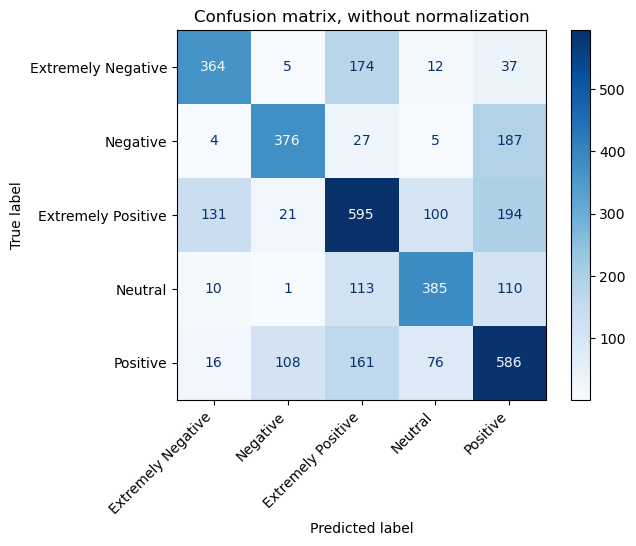

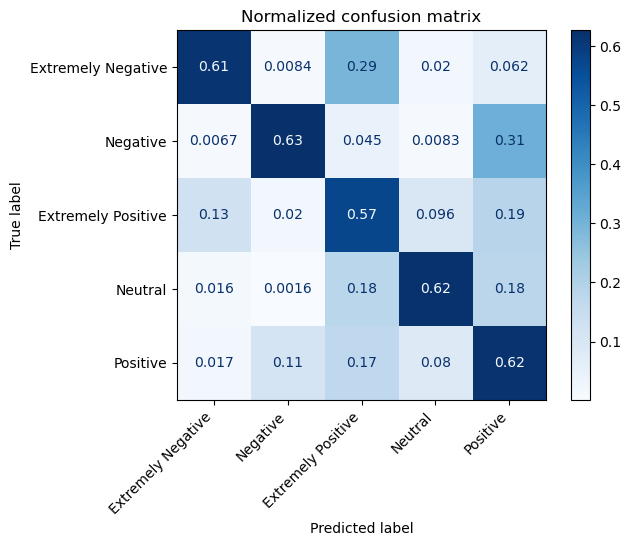

In [68]:
# Confusion Matrix and plots
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)
# Retrieve labels using tolist and set operation
class_names = set(df_test['Sentiment'].values.tolist())

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        MLP_4,
        X_test_count,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    plt.xticks(rotation=45, ha='right')

    print(title)
    print(disp.confusion_matrix)



plt.show()

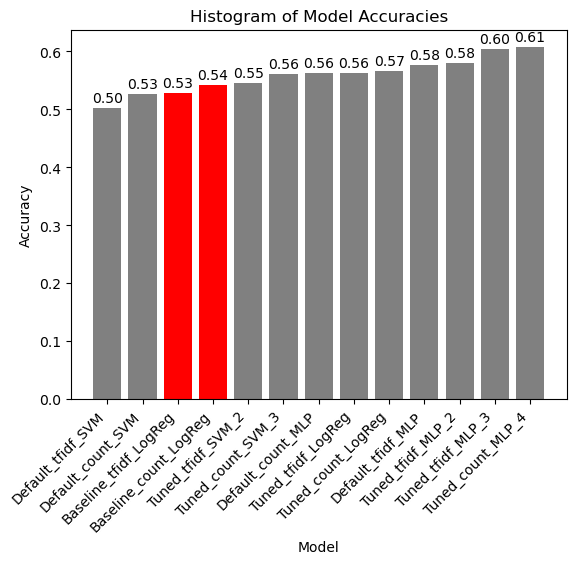

In [81]:
# A summary of accuracies of all trained models on bar chart
sorted_models = sorted(test_ac_dict.items(), key=lambda x: x[1])

x = [item[0] for item in sorted_models]
y = [item[1] for item in sorted_models]

# Setting baseline models as red
for i, val in enumerate(y):
    if i == 2: 
        plt.bar(x[i], val, color='red')
    elif i == 3:
        plt.bar(x[i], val, color='red')
    else:
        plt.bar(x[i], val, color = 'grey')

plt.title('Histogram of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')

for i, v in enumerate(y):
    # f"{v:.2f}" keep two decimals
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom')
    
plt.xticks(rotation=45, ha='right')

plt.show()

---

## Question 8 (10 points)

When the results of two models are similar, and anyway as a good practice, you may want to test whether their results **differ significantly**. If you can afford to do multiple paired runs of both models on different slices of the data (or different samples), a good approach is the [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html).

* Select two (or more) of your classifiers which have somewhat similar results on your validation data. Make sure to select two methods which do not take too long to run.
* Merge your train and validation data, and implement a function to shuffle and sample a % of datapoints (with labels) from it.
* Iterate 5-10 times the following steps:
   - Shuffle and sample 80% of your training datapoints.
   - Train instances of the two classifiers on the same 80% sample.
   - Assess their accuracy on the test dataset and store these results (into two separate lists for each classifier).
* Perform a Wilcoxon test on these results and discuss whether the two classifiers are significantly different on this task and dataset.

In [82]:
# your code here
from sklearn.utils import shuffle
from scipy.stats import wilcoxon

# We choose count-based SVM_3 and Tuned count-based LogReg, build functions based on them

def shuffle_and_sample(data, labels, percent):
    # Count_based, count-vectorizer
    X_merged = count_vectorizer.fit_transform(data)
    y_merged = labels

    # Shuffle and sample percent of data
    X_sampled, y_sampled = shuffle(X_merged, y_merged, random_state=42)
    sample_size = int(X_sampled.shape[0] * percent)
    X_sampled = X_sampled[:sample_size]
    y_sampled = y_sampled[:sample_size]
    
    return X_sampled, y_sampled


def evaluate_classifier(clf, X_test, y_test):
    # Count_based, count-vectorizer
    X_test_vec = count_vectorizer.transform(X_test)
    y_pred = clf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

SVM_3_accuracies = []
tuned_logreg_count_accuracies = []

for i in range(5):
    # Iterate 5 times, get 5 sample set pairs and classify 5 times
    X_sampled, y_sampled = shuffle_and_sample(Original_Tweet_trainfile, Sentiment_trainfile, 0.8)
    SVM_3.fit(X_sampled, y_sampled)
    logreg_t.fit(X_sampled, y_sampled)
    
    # Perform evaluations on the test set and add them to lists    
    ac_SVM_3 = evaluate_classifier(SVM_3, Original_Tweet_testfile, Sentiment_testfile)
    ac_logregt_c = evaluate_classifier(logreg_t, Original_Tweet_testfile, Sentiment_testfile)
    SVM_3_accuracies.append(ac_SVM_3)
    tuned_logreg_count_accuracies.append(ac_logregt_c)

statistic, p_value = wilcoxon(SVM_3_accuracies, tuned_logreg_count_accuracies)

print("Count-based SVM_3 accuracies:", SVM_3_accuracies)
print("Tuned Count-based LogReg accuracies:", tuned_logreg_count_accuracies)
print("Wilcoxon test statistic:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference between the two classifiers.")
else:
    print("There is no significant difference between the two classifiers.")

F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
F:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Count-based SVM_3 accuracies: [0.5529225908372828, 0.5529225908372828, 0.5529225908372828, 0.5529225908372828, 0.5529225908372828]
Tuned Count-based LogReg accuracies: [0.5713533438651922, 0.5721432332806741, 0.5721432332806741, 0.5716166403370195, 0.5716166403370195]
Wilcoxon test statistic: 0.0
p-value: 0.0625
There is no significant difference between the two classifiers.


---